# Monte Carlo Simulation

This file implements a simulation for various specified DGP's. 

A number of dependencies are necessary - particularly the accompanying function files. 

In [1]:
# IMPORT DEPENDENCIES
import numpy as np
import pandas as pd
import os 
import pickle
from datetime import datetime 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
import importlib

#Import own files 
import sys 
sys.path.append(r'..\functions')
import monte_carlo_simulation as mc
import dgp_stuff as dgp
import neural_net as nn
import estimators as est
import summaries as smr
import figurez as figz
import tablez as tblz


###############################################################################
# Load parameters (defined in simulation file)
parameters, estimators, g_functions = \
        mc.MC_load_pars('sec4_simulation_single_prod_2018_10_19') 

parameters

{'seed': 4256,
 'M': 100,
 'k': 5,
 'n': 100000,
 'V': 0,
 'C': 0,
 'Z': 0,
 'run_wellspecified': True,
 'add_error': False,
 'parallel': True,
 'decimals': 2,
 'reduce_size': True,
 'save_file': False,
 'filename': 'sec4_simulation_single_prod_2018_10_19',
 'start_time': datetime.datetime(2018, 10, 19, 18, 30, 8, 147480),
 'beta_distribution': <function dgp_stuff.draw_beta_normal(k=2, mu=1, stdev=1)>,
 'beta_mean': 1,
 'beta_scale': 1,
 'redraw': False,
 'x_distribution': <function dgp_stuff.draw_x_normal(mu, cov, n=10000, **kwargs)>,
 'x_distribution_parameters': <function dgp_stuff.gen_x_normal_unitvariance_randommean(k=2, mean=1)>,
 'x_mean': 0,
 'u_distribution': <function dgp_stuff.draw_u_normal(n, stdev=1)>,
 'u_scale': 1,
 'y_generate': <function dgp_stuff.gen_y_reg(g, u)>,
 'y_squashing': <function dgp_stuff.linear_output(s)>,
 'y_squashing_prime': <function dgp_stuff.linear_output_prime(s)>,
 'B': 0,
 'run_observables': False}

In [2]:
figtitle = '4_simulation_single_'
#table_subset = ['MLE', 'OLS (I)', 'OLS (II)', 'NN (I)', 'NN (II)']
table_subset = estimators.keys()
#table_functions = [g for g in g_functions.keys() if g not in ['Polynomial_3']]
table_functions = g_functions.keys()

comp_kws = {'coefficient':0}
mrgeff_file = 'res_mrgeffs'
expect_file = 'res_probs'
figtitle = '4_simulation_single_'

table_notes = '\TableIntroMSEMrgeff\TableMainAvgStd{' + '{:,}'.format(parameters['M']) \
                + '}{' + '{:,}'.format(parameters['k']) \
                + '}{continuous}{' + '{:,}'.format(parameters['n']) + '}'

### Distribution of average marginal effects 

In [3]:
# Average marginal effects 
res_mrgeffs_avg = smr.comp_wrapper_gseries(smr.comp_average, mrgeff_file,
                                           comp_kws = comp_kws,
                                           g_functions=g_functions, 
                                           filename = parameters['filename'])
fig_name = 'mrgeff_avg_distribution'

C:\Users\rbjoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


In [4]:
# Calculate some stuff for the figures 
dgp_averages = [np.mean(res_mrgeffs_avg[g]['DGP']['Test']) for g in res_mrgeffs_avg.keys()]
x_interval = [.05,.1,.15,
             .15,.2,.05,
             .05,.2,.1,]  
xmin = list(np.array(dgp_averages)-np.array(x_interval))
xmax = list(np.array(dgp_averages)+np.array(x_interval))

ymax = [105,40,25,
        40,12,45, 
        55,18,30,]

C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


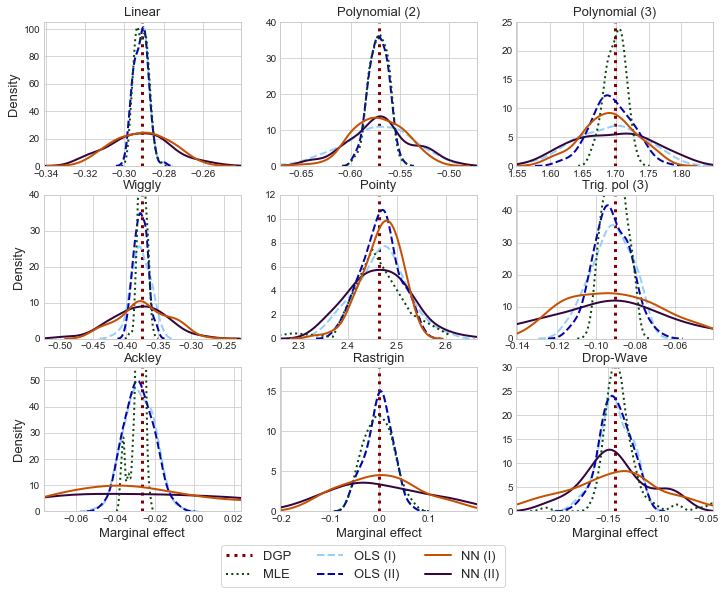

In [5]:
figz.fig_wrapper_g(g_series = res_mrgeffs_avg,
                   g_figfunc = figz.fig_distribution, 
                  g_functions=g_functions, estimators=estimators, 
                  save_file=True, filename=figtitle+fig_name, 
                  legend = 'figure',DGP_last=False,
                  xlabel_last = 'Marginal effect',
                  ylabel_first = 'Density',
                  xmin = xmin,
                  xmax = xmax,
                  ymax = ymax, 
                  share_y=False, share_x=False)

C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


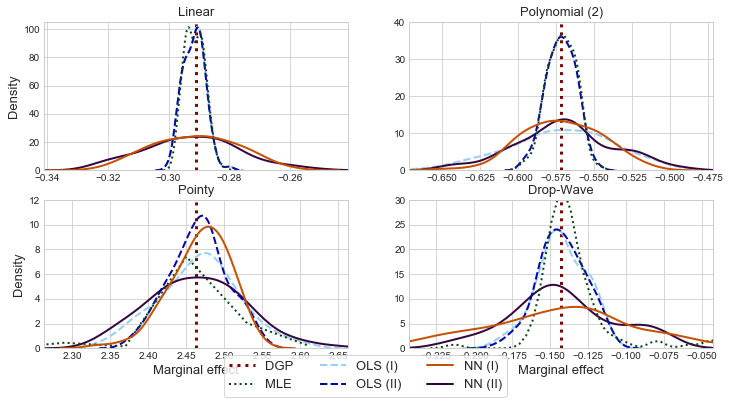

In [6]:
subset = [1,2,5,9]

def get_subset(full_list, subset):
    return [full_list[i-1] for i in subset]

figz.fig_wrapper_g(g_series = res_mrgeffs_avg,
                   g_figfunc = figz.fig_distribution, 
                  g_functions=g_functions, estimators=estimators, 
                  save_file=True, filename=figtitle+fig_name+'_subset', 
                  legend = 'figure',DGP_last=False,
                   n_cols =2, n_rows = 2,
                  subset = get_subset(list(g_functions.keys()), subset),
                  xmin = get_subset(xmin, subset),
                  xmax = get_subset(xmax, subset), 
                  ymax = get_subset(ymax, subset),
                  xlabel_last = 'Marginal effect',
                  ylabel_first = 'Density',
                  share_y=False, share_x=False)

### Mean MSE for marginal effects

In [5]:
res_mrgeffs_mmse = smr.comp_wrapper_gseries(smr.comp_mmse,mrgeff_file, dgp_series = mrgeff_file, 
                                           g_functions=g_functions, 
                                           filename = parameters['filename'])

In [6]:
tblz.table_wrapper_g(g_series = res_mrgeffs_mmse,
                        cell_function =tblz.table_cell_avgstd, 
                        g_functions=g_functions, 
                        decimals=parameters['decimals'], print_string=False, 
                        #g_subset = table_functions,
                        #models = table_subset,
                        save_file = True, filename=figtitle+'table_mrgeff_MMSE', 
                        caption='Neural networks are preferred  based on MSE!', 
                        label=figtitle+'table_mrgeff_MMSE', 
                        note1=table_notes)

C:\Users\rbjoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:112: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


,DGP,MLE,OLS (I),OLS (II),NN (I),NN (II)
Linear,0.00 (0.000),0.00 (0.000),0.00 (0.000),0.00 (0.000),0.01 (0.001),0.01 (0.002)
Polynomial (2),0.00 (0.000),0.00 (0.000),7.46 (0.025),0.00 (0.000),0.54 (0.068),0.31 (0.048)
Polynomial (3),0.00 (0.000),0.00 (0.000),16.15 (0.086),6.58 (0.057),2.44 (0.293),1.22 (0.187)
Wiggly,0.00 (0.000),0.00 (0.000),4.41 (0.014),3.36 (0.011),0.48 (0.038),0.36 (0.029)
Pointy,0.00 (0.000),29.75 (26.579),46.80 (0.067),18.50 (0.084),1.96 (0.236),1.65 (0.171)
Trig. pol (3),0.00 (0.000),0.00 (0.000),0.68 (0.002),0.49 (0.003),0.05 (0.006),0.04 (0.003)
Ackley,0.00 (0.000),7.86 (0.220),8.00 (0.020),7.95 (0.020),2.71 (0.160),1.97 (0.117)
Rastrigin,0.00 (0.000),0.00 (0.000),102.21 (0.150),102.22 (0.150),20.37 (3.118),12.06 (2.224)
Drop-Wave,0.00 (0.000),inf (nan),7.29 (0.015),7.13 (0.016),2.80 (0.145),0.52 (0.051)


### MRSE for average marginal effects

In [9]:
res_avgmrg_mse = smr.comp_wrapper_gseries(smr.comp_mrse_avg,mrgeff_file, dgp_series = mrgeff_file, 
                                           g_functions=g_functions, 
                                           filename = parameters['filename'])

C:\Users\rbjoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
C:\Users\rbjoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [10]:
tblz.table_wrapper_g(g_series = res_avgmrg_mse,
                        cell_function =tblz.table_cell_avgstd, 
                        g_functions=g_functions, 
                        decimals=parameters['decimals'], print_string=False, 
                        #g_subset = table_functions,
                        #models = table_subset,
                        save_file = True, filename=figtitle+'table_avgmrg_MSE', 
                        caption='MSE for average marginal effects.', 
                        label=figtitle+'table_avgmrg_MSE', 
                        note1=table_notes)

,DGP,MLE,OLS (I),OLS (II),NN (I),NN (II)
Linear,0.00 (0.000),0.00 (0.001),0.00 (0.001),0.00 (0.001),0.01 (0.004),0.01 (0.006)
Polynomial (2),0.00 (0.000),0.00 (0.002),0.03 (0.016),0.01 (0.002),0.02 (0.006),0.03 (0.009)
Polynomial (3),0.00 (0.000),0.00 (0.002),0.04 (0.017),0.02 (0.009),0.03 (0.010),0.04 (0.013)
Wiggly,0.00 (0.000),0.84 (0.003),0.01 (0.006),0.01 (0.004),0.03 (0.009),0.03 (0.012)
Pointy,0.00 (0.000),2.62 (0.386),0.04 (0.015),0.03 (0.011),0.03 (0.012),0.05 (0.016)
Trig. pol (3),0.00 (0.000),0.00 (0.002),0.01 (0.005),0.01 (0.004),0.02 (0.006),0.03 (0.010)
Ackley,0.00 (0.000),0.01 (0.005),0.01 (0.004),0.01 (0.004),0.03 (0.008),0.04 (0.013)
Rastrigin,0.00 (0.000),0.00 (0.001),0.03 (0.012),0.03 (0.012),0.06 (0.019),0.07 (0.035)
Drop-Wave,0.00 (0.000),0.05 (nan),0.01 (0.004),0.01 (0.004),0.04 (0.014),0.03 (0.011)


### Mean MSE for expectation

In [11]:
res_expect_mse = smr.comp_wrapper_gseries(smr.comp_mse,expect_file, dgp_series = expect_file, 
                                           g_functions=g_functions, 
                                           filename = parameters['filename'])

In [12]:
tblz.table_wrapper_g(g_series = res_expect_mse,
                        cell_function =tblz.table_cell_avgstd, 
                        g_functions=g_functions, 
                        decimals=parameters['decimals'], print_string=False, 
                        #g_subset = table_functions,
                        #models = table_subset,
                        save_file = True, filename=figtitle+'table_expect_MSE', 
                        caption='MSE for expectation.', 
                        label=figtitle+'table_excpect_MSE', 
                        note1=table_notes)

,DGP,MLE,OLS (I),OLS (II),NN (I),NN (II)
Linear,0.00 (0.000),0.00 (0.000),0.00 (0.000),0.00 (0.000),0.00 (0.002),0.01 (0.003)
Polynomial (2),0.00 (0.000),0.00 (0.000),31.98 (0.347),0.00 (0.000),0.11 (0.023),0.06 (0.015)
Polynomial (3),0.00 (0.000),0.00 (0.000),41.66 (0.575),9.69 (0.210),0.50 (0.105),0.19 (0.054)
Wiggly,0.00 (0.000),0.00 (0.000),6.90 (0.079),2.83 (0.020),0.13 (0.023),0.09 (0.025)
Pointy,0.00 (0.000),92.66 (145.004),73.40 (0.437),23.57 (0.273),0.23 (0.060),0.21 (0.055)
Trig. pol (3),0.00 (0.000),0.00 (0.000),1.50 (0.017),0.88 (0.014),0.02 (0.005),0.02 (0.007)
Ackley,0.00 (0.000),0.92 (0.036),1.19 (0.006),0.95 (0.005),0.21 (0.025),0.15 (0.020)
Rastrigin,0.00 (0.000),0.00 (0.000),12.96 (0.047),12.95 (0.047),1.84 (0.463),0.93 (0.353)
Drop-Wave,0.00 (0.000),73.81 (725.784),3.88 (0.011),3.69 (0.011),0.83 (0.078),0.08 (0.023)


### Distribution of marginal effects (pooled)

In [13]:
res_mrgeffs_pooled = smr.comp_wrapper_gseries(smr.comp_pool_simulations,mrgeff_file, 
                                           g_functions=g_functions,
                                           comp_kws = comp_kws, #Look at one beta.
                                           filename = parameters['filename'])
fig_name = 'mrgeffs_pooled_distribution'

In [14]:
# Calculate some stuff for the figures 
linear_averages = [np.mean(res_mrgeffs_avg[g]['OLS (I)']['Test']) for g in res_mrgeffs_avg.keys()]
x_interval = [.2,7,7.5,
             4,15,2.5,
             7.5,20,10,]  
xmin = list(np.array(dgp_averages)-np.array(x_interval))
xmax = list(np.array(dgp_averages)+np.array(x_interval))

ymax = [15,.175,.35,
        .7,.12,.9, 
        .375,.13,.25,]

C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\rbjoe\Anaconda3\lib\site-packages\numpy\core\_methods.py:70: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


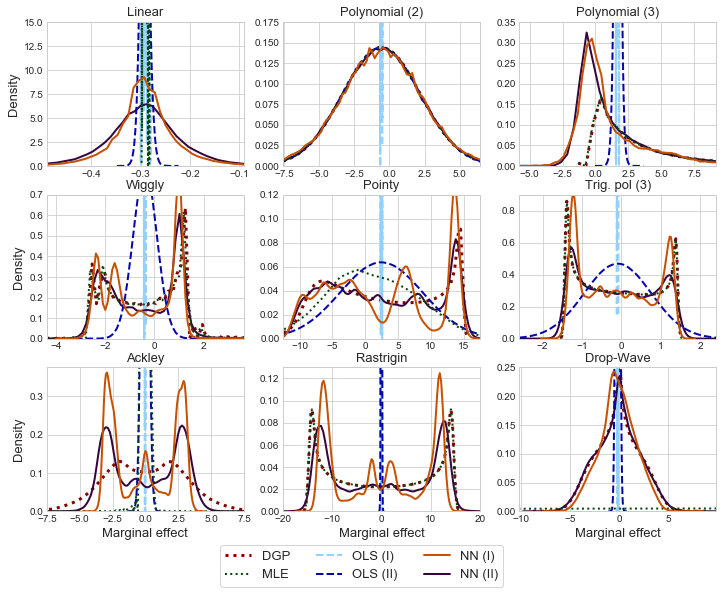

In [15]:
figz.fig_wrapper_g(g_series = res_mrgeffs_pooled, g_figfunc = figz.fig_distribution_pool,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   #n_rows =1, n_cols=2, 
                   save_file=True, filename=figtitle+fig_name,
                  #titles=g_functions,
                   share_y=False, share_x=False, 
                   legend = 'figure',
                  xmin = xmin,
                  xmax = xmax,
                  ymax = ymax, 
                  xlabel_last = 'Marginal effect',
                  ylabel_first = 'Density',                   
                  )

C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


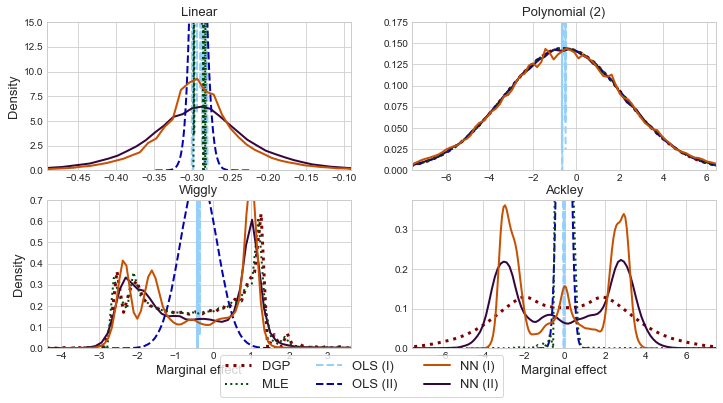

In [16]:
subset = [1,2,4,7]
figz.fig_wrapper_g(g_series = res_mrgeffs_pooled, g_figfunc = figz.fig_distribution_pool,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   save_file=True, filename=figtitle+fig_name+'_subset',
                   #titles=g_functions, 
                   share_y=False, share_x=False, 
                   legend = 'figure',
                   n_rows =2, n_cols=2, 
                  subset = get_subset(list(g_functions.keys()), subset),
                  xmin = get_subset(xmin, subset),
                  xmax = get_subset(xmax, subset), 
                  ymax = get_subset(ymax, subset),
                  xlabel_last = 'Marginal effect',
                  ylabel_first = 'Density',                   
                   )

### Distribution of marginal effects (one sample)

In [17]:
#importlib.reload(smr)
res_mrgeffs_sample = smr.comp_wrapper_gseries(smr.comp_sample_simulation,mrgeff_file, 
                                           g_functions=g_functions,
                                           comp_kws = comp_kws, #Look at one beta.
                                           filename = parameters['filename'])
fig_name = 'mrgeffs_sample_distribution'

In [18]:
# Calculate some stuff for the figures 
linear_averages = [np.mean(res_mrgeffs_avg[g]['OLS (I)']['Test']) for g in res_mrgeffs_avg.keys()]
x_interval = [.2,7,7.5,
             4,15,2.5,
             7.5,20,10,]  
xmin = list(np.array(dgp_averages)-np.array(x_interval))
xmax = list(np.array(dgp_averages)+np.array(x_interval))

ymax = [15,.175,.35,
        .6,.11,.85, 
        .375,.125,.2,]

C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


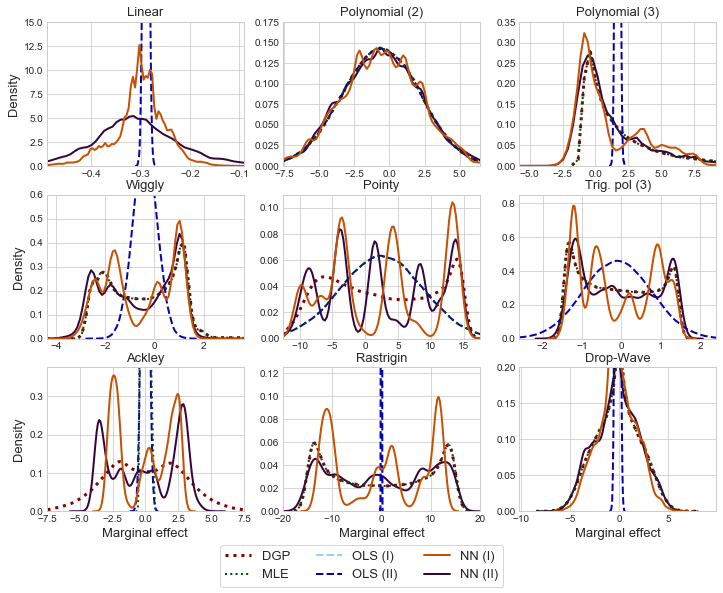

In [19]:
figz.fig_wrapper_g(g_series = res_mrgeffs_sample, g_figfunc = figz.fig_distribution_pool,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   save_file=True, filename=figtitle+fig_name,
                   #titles=g_functions, 
                   share_y=False, share_x=False, 
                   legend = 'figure',
                  xmin = xmin,
                  xmax = xmax,
                  ymax = ymax, 
                  xlabel_last = 'Marginal effect',
                  ylabel_first = 'Density',                   
                   )

C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\rbjoe\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


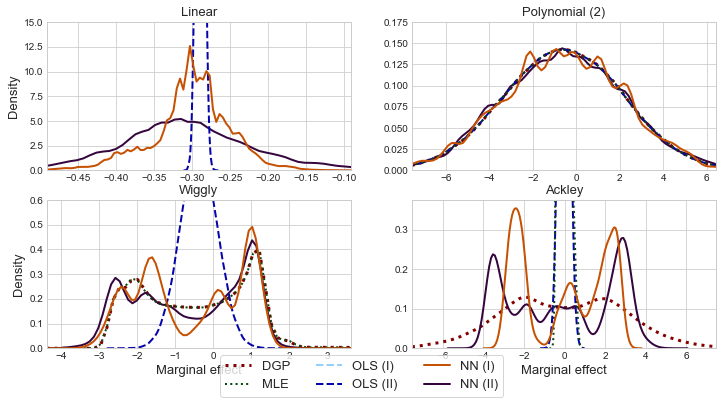

In [20]:
subset = [1,2,4,7]
figz.fig_wrapper_g(g_series = res_mrgeffs_sample, g_figfunc = figz.fig_distribution_pool,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   save_file=True, filename=figtitle+fig_name+'_subset',
                   #titles=g_functions, 
                   share_y=False, share_x=False, 
                   legend = 'figure',
                   n_rows =2, n_cols=2, 
                  subset = get_subset(list(g_functions.keys()), subset),
                  xmin = get_subset(xmin, subset),
                  xmax = get_subset(xmax, subset), 
                  ymax = get_subset(ymax, subset),
                  xlabel_last = 'Marginal effect',
                  ylabel_first = 'Density',                   
                   )

### Marginal effect as function of the regressor (pooled)

In [21]:
importlib.reload(smr)
comp_kws.update({'percentiles':50})
res_mrgeffs_pool_grpby = smr.comp_wrapper_gseries(smr.comp_pool_simulation_includex,mrgeff_file, 
                                           g_functions=g_functions,
                                            y = 'data', data_variable='x', #Add data for group by
                                           comp_kws = comp_kws, #Look at one beta.
                                           filename = parameters['filename'])
fig_name = 'mrgeffs_pooled_function'

In [22]:
#Calculate some stuff for the figures 
ymax = [-0.31,'-','-',
        '-','-','-', 
        '-','-','-',]
ymin = [-0.27,'-','-',
        '-','-','-', 
        '-','-','-',]


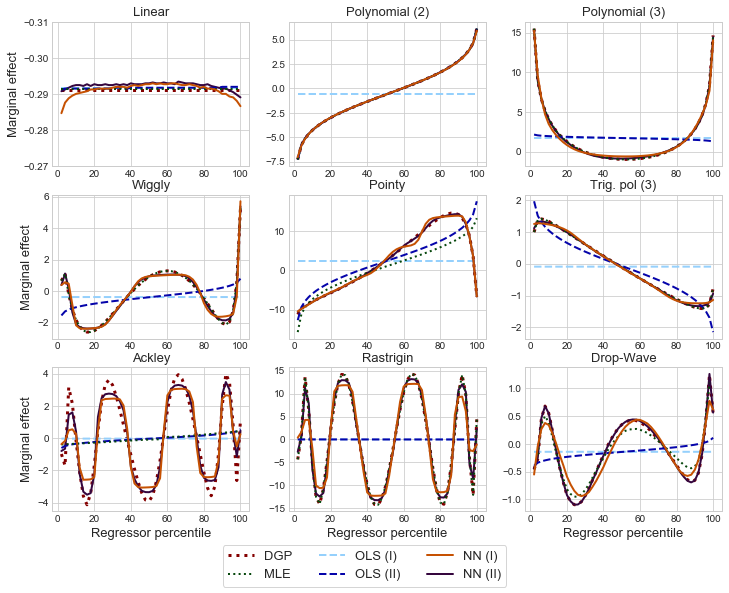

In [23]:
importlib.reload(figz)
figz.fig_wrapper_g(g_series = res_mrgeffs_pool_grpby, g_figfunc = figz.fig_plot_mrgeff_grpby,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   save_file=True, filename=figtitle+fig_name,
                   #titles=g_functions, 
                   share_y=False, share_x=False, 
                   legend = 'figure', 
                  #xmin = xmin,
                  #xmax = xmax,
                  ymax = ymax,
                  ymin = ymin,
                  xlabel_last = 'Regressor percentile',
                  ylabel_first = 'Marginal effect',                   
                   )

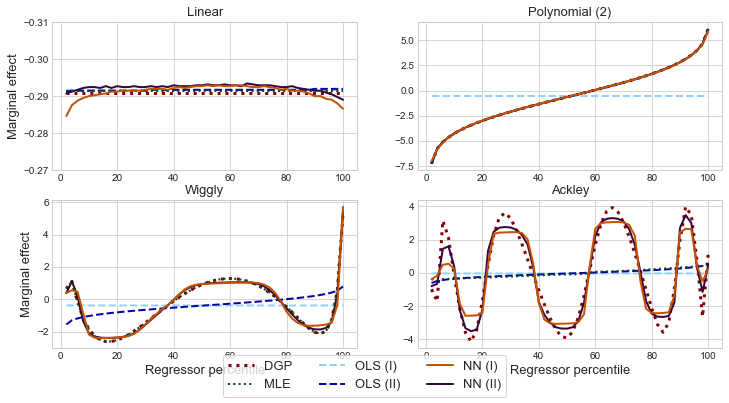

In [24]:
importlib.reload(figz)
subset = [1,2,4,7]
figz.fig_wrapper_g(g_series = res_mrgeffs_pool_grpby, g_figfunc = figz.fig_plot_mrgeff_grpby,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   save_file=True, filename=figtitle+fig_name+'_subset',
                   #titles=g_functions, 
                   share_y=False, share_x=False, 
                   legend = 'figure', 
                   n_rows =2, n_cols=2, 
                  subset = get_subset(list(g_functions.keys()), subset),
                  #xmin = get_subset(xmin, subset),
                  #xmax = get_subset(xmax, subset), 
                  ymax = get_subset(ymax, subset),
                  ymin = get_subset(ymin, subset),
                  xlabel_last = 'Regressor percentile',
                  ylabel_first = 'Marginal effect',                       
                   )

### Marginal effect as function of the regressor (one sample)

In [25]:
importlib.reload(smr)
comp_kws.update({'percentiles':50})
res_mrgeffs_sample_grpby = smr.comp_wrapper_gseries(smr.comp_sample_simulation_includex,mrgeff_file, 
                                           g_functions=g_functions,
                                            y = 'data', data_variable='x', #Add data for group by
                                           comp_kws = comp_kws, #Look at one beta.
                                           filename = parameters['filename'])
fig_name = 'mrgeffs_sample_function'

In [26]:
#Calculate some stuff for the figures 
ymax = [-0.33,'-','-',
        '-','-','-', 
        '-','-','-',]
ymin = [-0.25,'-','-',
        '-','-','-', 
        '-','-','-',]


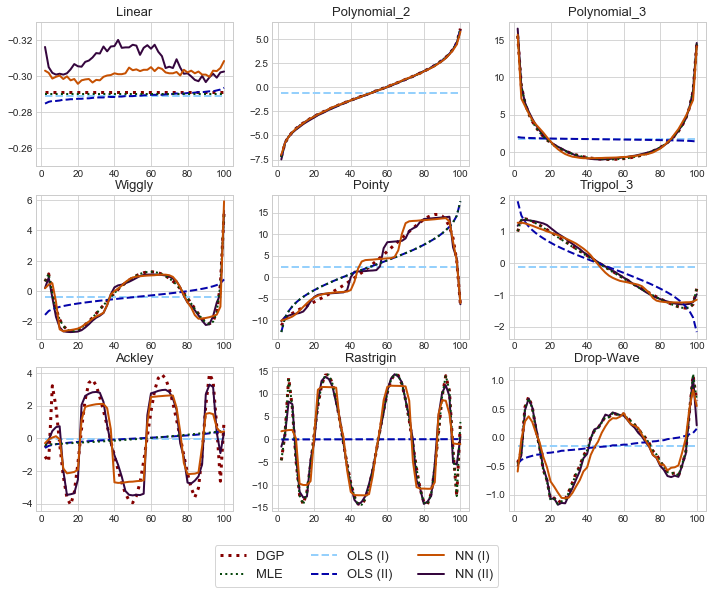

In [27]:
importlib.reload(figz)
figz.fig_wrapper_g(g_series = res_mrgeffs_sample_grpby, g_figfunc = figz.fig_plot_mrgeff_grpby,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   #n_rows =1, n_cols=2, 
                   save_file=True, filename=figtitle+fig_name,
                  titles=g_functions, share_y=False, share_x=False, 
                   legend = 'figure', 
                  #xmin = xmin,
                  #xmax = xmax,
                  ymax = ymax,
                  ymin = ymin,
                  )

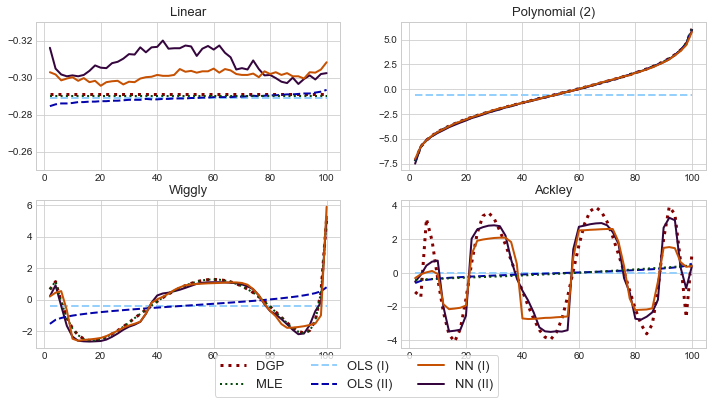

In [28]:
importlib.reload(figz)
figz.fig_wrapper_g(g_series = res_mrgeffs_sample_grpby, g_figfunc = figz.fig_plot_mrgeff_grpby,
                   g_functions = g_functions, estimators = estimators, 
                   #models = ['DGP', 'Logit (I)', 'NN (I)'],
                   save_file=True, filename=figtitle+fig_name+'_subset',
                   #titles=g_functions, 
                   share_y=False, share_x=False, 
                   legend = 'figure', 
                   n_rows =2, n_cols=2, 
                  subset = get_subset(list(g_functions.keys()), subset),
                  #xmin = get_subset(xmin, subset),
                  #xmax = get_subset(xmax, subset), 
                  ymax = get_subset(ymax, subset),
                  ymin = get_subset(ymin, subset),
                   )